# Load and initialize

settings

In [1]:
# sample number

j='1'

singleSample = True
# n_samples = 10000
    # create visualization (umap, dbscan are always shown)
visualize = False
plotUMAP  = True
    # show figures in notebook
show = True




envirement

In [2]:
import os

import time 
start = time.process_time()
import datetime 
date = datetime.date.today().strftime("%d%m%Y")
import pathlib
import sys
from IPython.display import Image, display
from tqdm import tqdm_notebook,tqdm
# import time

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

plt.rcParams["figure.figsize"] = (5.0, 4.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
%matplotlib inline

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 180) #according to screen width
# from pandas.core.base import PandasObject
# PandasObject.view = view #allows view meth pd.view

# from scipy import signal, stats
# import seaborn as sns

# from sklearn import metrics

# from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
# from sklearn.metrics import silhouette_samples,silhouette_score
# from sklearn.neighbors import kneighbors_graph

# from lmfit import minimize, Parameters


parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dir_data = os.path.abspath(os.path.join(parent_dir, os.pardir))+'/Data/'
sys.path.append(parent_dir+'/functions/')


from usefull_functions import *
from functions import *
from plot_functions import *
from clustering_functions import *
# from epinuc import *



%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%autoreload 2


dir_plots = os.path.abspath(os.path.join(parent_dir, os.pardir))+f'/_sample_{j}_{date}/'
saveSVG  =False
settings =        (dir_plots,show,saveSVG)
folderExists(dir_plots)

TF_ENABLE_ONEDNN_OPTS=0

load data; normalized (CD45-)  

In [3]:
j = getJ(j)
k_orig = pickle_load('k'+j+'_dict',dir_data )['k']
print(len(k_orig))

dict = pickle_load('k'+j+'_names_dict',dir_data )
NamesAll = dict['NamesAll']
CellIden = dict['CellIden']
EpiCols = dict['EpiCols']
Core = dict['Core']
CellIden_EpiCols = CellIden + EpiCols


groups = [['CellIden','EpiCols','CellIden+EpiCols'],[CellIden,EpiCols,CellIden_EpiCols]]
del dict


current j = 1
k1_dict ; loaded from file
1772
k1_names_dict ; loaded from file


Visualize data

no point to print data.describe() as it is whitened (std~1, mean~0) 

In [4]:
if show:

    for name in [NamesAll,Core,CellIden,EpiCols,CellIden_EpiCols]:
        print(len(name))
        print(name)


34
['H4', 'H3', 'H3.3', 'K5', 'EpCam', 'H3K27me2', 'p53', 'EZH2', 'gH2AX', 'aSMA', 'H3K36me2', 'H3K4me1', 'H3K9me2', 'H4K16ac', 'H2Aub', 'Vimentin', 'H3K64ac', 'BMI-1', 'ZEB1', 'H3K27ac', 'H4K20me3', 'ER', 'CD49f', 'CD24', 'GATA3', 'H3K9ac', 'H3K9me3', 'CD44', 'Ki67', 'K8-18', 'H3S28p', 'H3K36me3', 'H3K4me3', 'H3K27me3']
3
['H4', 'H3', 'H3.3']
13
['K5', 'EpCam', 'aSMA', 'Vimentin', 'ZEB1', 'ER', 'CD49f', 'CD24', 'GATA3', 'CD44', 'K8-18', 'Ki67', 'p53']
18
['H3K27me2', 'H3K36me2', 'H3K4me1', 'H3K9me2', 'H4K16ac', 'H2Aub', 'H3K64ac', 'H3K27ac', 'H4K20me3', 'BMI-1', 'EZH2', 'gH2AX', 'H3K9ac', 'H3K9me3', 'H3S28p', 'H3K36me3', 'H3K4me3', 'H3K27me3']
31
['K5', 'EpCam', 'aSMA', 'Vimentin', 'ZEB1', 'ER', 'CD49f', 'CD24', 'GATA3', 'CD44', 'K8-18', 'Ki67', 'p53', 'H3K27me2', 'H3K36me2', 'H3K4me1', 'H3K9me2', 'H4K16ac', 'H2Aub', 'H3K64ac', 'H3K27ac', 'H4K20me3', 'BMI-1', 'EZH2', 'gH2AX', 'H3K9ac', 'H3K9me3', 'H3S28p', 'H3K36me3', 'H3K4me3', 'H3K27me3']


# Cell Identity

In [5]:
k = k_orig.copy()
CAll=pd.concat([k]).copy()
s ={}
s['min_dist'] = {}
s['n_neighbors'] = {}
s['min_samples'] = {}
s['eps'] = {}


name = 'Tumor'+j+'_CellIden_'


### UMAP

plot for each feature according to its intensity

0.07 200
UMAP(min_dist=0.07, n_neighbors=200, random_state=42, verbose=True)
Sun Apr  2 09:45:12 2023 Construct fuzzy simplicial set
Sun Apr  2 09:45:13 2023 Finding Nearest Neighbors
Sun Apr  2 09:45:15 2023 Finished Nearest Neighbor Search
Sun Apr  2 09:45:17 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Apr  2 09:45:23 2023 Finished embedding


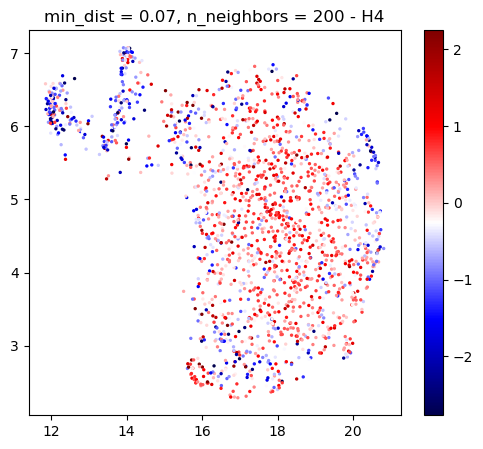

In [6]:
min_dist,n_neighbors = getValsCsv(vars = ['iden','umap',j])
print(min_dist,n_neighbors)


umapData = calculate_umap(CAll[CellIden],n_neighbors, min_dist)
  

drawUMAP(umapData, ['H4'],CAll,settings,
            title = f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
            Figname = name+'1_UMAP_(core)')

# umap_params(k,CellIden,dir_plots,
#             valA = min_dist, valB = n_neighbors
#             )

# if j=='4':
#     ind  = np.where(umapData[:,0]<5)
#     k_orig.drop(k_orig.index[ind],inplace=True)
#     k = k_orig.copy();CAll=pd.concat([k]).copy()
    
    # umapData = calculate_umap(CAll[CellIden],n_neighbors, min_dist)
    # drawUMAP(umapData, ['H4'],CAll,settings,
    #             title = f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
    #             Figname = name+'1_UMAP_(core)')
    


### Dbscan and clusters

0.19 50
Estimated number of clusters: 1
Estimated number of noise points: 1673
Silhouette Coefficient: 0.409


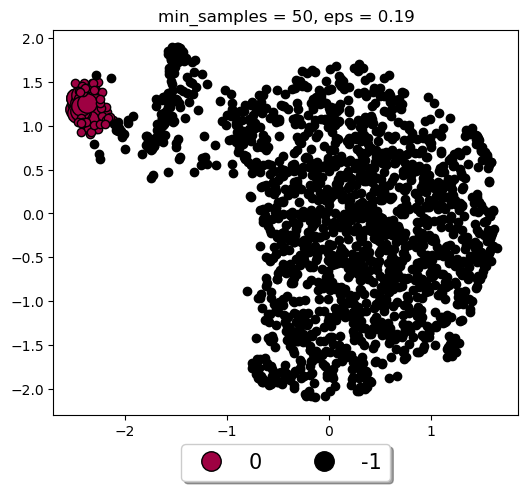

In [7]:
eps,min_samples = getValsCsv(vars = ['iden','db',j])
print(eps,min_samples)
dbscanData,labels,core_samples_mask = calculate_dbscan(umapData,eps,min_samples)

drawDbscan(dbscanData,labels,core_samples_mask,settings,
        title=f'min_samples = {min_samples}, eps = {eps}',
        figname = name+'1_dbscan')
              
  


# dbscan_params(X_2d,
#                   valA = eps, valB = min_samples,
#                   itersA = 3, itersB = 3,
#                   )


/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


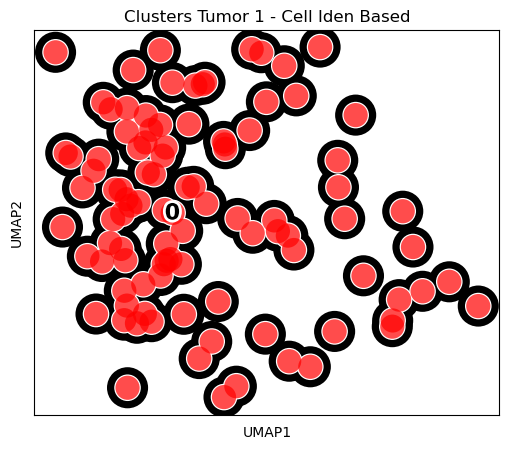

In [8]:

plotClusters(k,umapData,labels,NamesAll,settings,
             title = 'Clusters Tumor '+j+' - Cell Iden Based',
             figname = name+'1_Clusters')
             



### HeatMap by clusters

In [9]:
### HeatMap by clusters
            
if visualize:
    for group_name,group in zip(groups[0],groups[1]):
        group_name,group = groups[0][-1],groups[1][-1]
        HeatMap(k[k.Clust!=-1],group,settings,
                title = 'T'+j+' Cell Iden Based: '+group_name,
                figname = name+'1_HeatMap_'+group_name)


### HeatMap by sample

In [10]:
if visualize and not singleSample :
    for group_name,group in zip(groups[0],groups[1]):
        group_name,group = groups[0][-1],groups[1][-1]
        HeatMap(k[k.Clust!=-1],group,settings,clustFeature='by_sample',
                title = 'T'+j+' Cell Iden Based: '+group_name+'by_sample',
                figname = name+'1_HeatMap_'+group_name+'by_sample')


### MeanDist

In [11]:

if visualize:
    for group_name,group in zip(groups[0],groups[1]):
        MeanDist(k [k.Clust==0],k [k.Clust==1],group,settings,
                title='MeanDist CellIdentity based: '+group_name,
                figname = name+'1_MeanDist_'+group_name)


## sample percentage

In [12]:
if visualize and not singleSample:
    # unique by_sample values
    sampNums = np.unique(k['by_sample'])
    for sampNum in sampNums:
        drawUMAPbySample(umapData, k, sampNum,'by_sample',settings,
                            title =name+' UMAP', 
                            Figname = name+f'4_UMAP_sample{sampNum}')

    arr =[]
    clustNums = np.unique(k.Clust); clustNums = clustNums[clustNums!=-1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind],'by_sample')

        arr.append([clustNum,PercentageBySample])
    saveCsv(dir_plots,name,arr)

## features on UMAP

In [13]:
# if visualize and plotUMAP:
#     drawUMAP(umapData, NamesAll,CAll,settings,
#             title ='Tumor'+j+ ' Cell Iden UMAP', 
#             Figname = name+'2_UMAP_')

# figures

In [14]:

if visualize :
    scatter(k,'NCad','ECad',name,settings)

## save data to file

In [15]:
dbscanData, umapData,k, CAll,labels,s = None,None,None,None,None,None

# Epigenetics Based

In [16]:


k = k_orig.copy()
CAll=pd.concat([k]).copy()

s ={}
s['min_dist'] = {}
s['n_neighbors'] = {}
s['min_samples'] = {}
s['eps'] = {}

name = 'Tumor'+j+'_EpiCols_'





### UMAP

plot for each feature according to its intensity

0.07 200
UMAP(min_dist=0.07, n_neighbors=200, random_state=42, verbose=True)
Sun Apr  2 09:45:26 2023 Construct fuzzy simplicial set
Sun Apr  2 09:45:27 2023 Finding Nearest Neighbors
Sun Apr  2 09:45:27 2023 Finished Nearest Neighbor Search
Sun Apr  2 09:45:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Apr  2 09:45:33 2023 Finished embedding


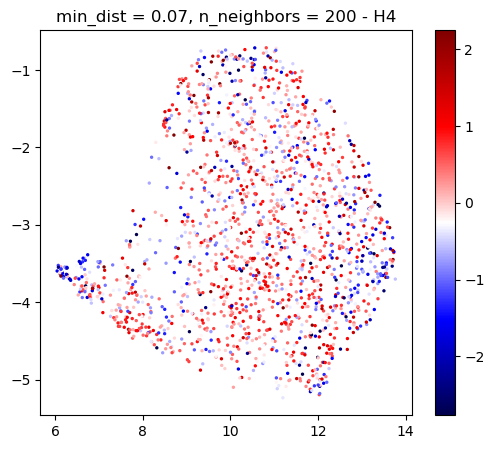

In [17]:
min_dist,n_neighbors = getValsCsv(vars = ['epi','umap',j])
print(min_dist,n_neighbors)


umapData = calculate_umap(CAll[EpiCols],n_neighbors, min_dist)
drawUMAP(umapData, ['H4'],CAll,settings,
            title = f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
            Figname = name+'1_UMAP_(core)')
    


# umap_params(k,MRK,dir_plots,
#             valA = min_dist, valB = n_neighbors,
#             )

# umap_params(k,MRK,dir_plots,
#             valA = 0.2, valB = 300,
#             )
# umap_params(k,MRK,dir_plots,
#             valA = 0.1, valB = 300,
#             )

# umap_params(k,MRK,dir_plots,
#             valA = 0.001, valB = 300,
#             )

### Dbscan and clusters

0.4 80
Estimated number of clusters: 2
Estimated number of noise points: 246
Silhouette Coefficient: 0.286


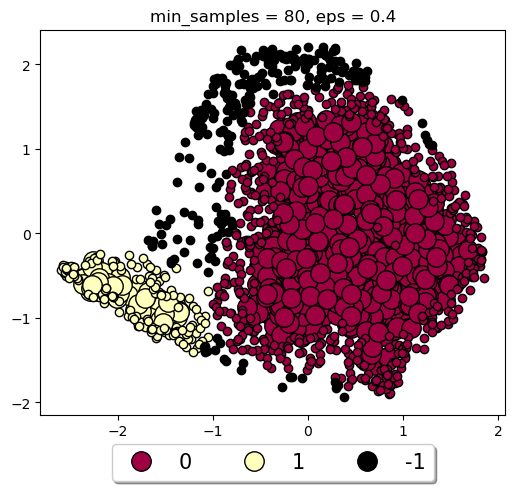

In [18]:
eps,min_samples = getValsCsv(vars = ['epi','db',j])
print(eps,min_samples)

dbscanData,labels,core_samples_mask = calculate_dbscan(umapData,eps=eps,min_samples=min_samples)
drawDbscan(dbscanData,labels,core_samples_mask,settings,
            title=f'min_samples = {min_samples}, eps = {eps}',
            figname = name+'1_dbscan')
            
# dbscan_params(X_2d,dir_plots,
#                   valA = eps, valB = min_samples,
#                   itersA = 3, itersB = 3,
#                   )


/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


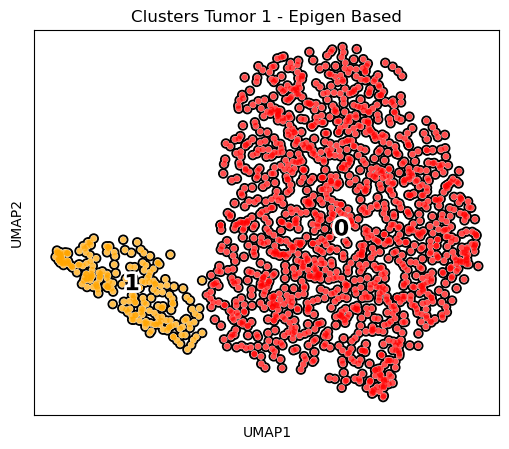

In [19]:
plotClusters(k,umapData,labels,NamesAll,settings,
             title = 'Clusters Tumor '+j+' - Epigen Based',
             figname = name+'1_Clusters')


## HeatMap by cluster

In [20]:

if visualize:
    for group_name,group in zip(groups[0],groups[1]):
    
        HeatMap(k[k.Clust!=-1],group,settings,
                title = 'T'+j+' Epigen Based: '+group_name,
                figname = name+'1_HeatMap_'+group_name)


### HeatMap by sample

In [21]:

if visualize and not singleSample:

    group_name,group = groups[0][-1],groups[1][-1]
    HeatMap(k[k.Clust!=-1],group,settings,clustFeature='by_sample',
            title = 'T'+j+' Cell Iden Based: '+group_name+'by_sample',
            figname = name+'1_HeatMap_'+group_name+'by_sample')


epinuc

In [22]:
# Kepinuc = loadEpinuc("EPINUC_BCK.csv",sampleMax=5)

# # group_name,group = groups[0][-1],groups[1][-1]
# # HeatMap(k,group,settings,clustFeature='by_sample',
# #         title = 'T'+j+' Cell Iden Based: '+group_name+'by_sample',
# #         figname = name+'1_HeatMap_'+group_name+'by_sample')
# Mat=   k.groupby(by='by_sample').mean()[Kepinuc.columns]
# Mat.index = Mat.index.astype(int).astype(str)+'_cytof'
# Kepinuc = Kepinuc.append(Mat)
# # print(Kepinuc)
# # print(Kepinuc.T.corr())

# import matplotlib.pyplot as plt
# from matplotlib.pyplot import cm
# import seaborn as sns
# g=sns.clustermap(Kepinuc.T.corr(),cmap=plt.cm.seismic,
#                 #  vmin=amin,vmax=amax,
#                 # figsize=(10,20), annot_kws={"size":8}, center=0,
#                 figsize=(6, 10), annot_kws={"size":8}, center=0,
#                 annot=True, linewidths=1,linecolor='k',)
# g.ax_col_dendrogram.set_title('corr map') 
# plt.savefig('corr.png', format="png", bbox_inches="tight", pad_inches=0.2)

## Meandist

In [23]:
if visualize:
    for group_name,group in zip(groups[0],groups[1]):
        MeanDist(k [k.Clust==0],k [k.Clust==1],group,settings,
                title='MeanDist Epigen based: '+group_name,
                figname = name+'1_MeanDist_'+group_name)


## sample percentage

In [24]:
if visualize and not singleSample:
    # unique by_sample values
    sampNums = np.unique(k['by_sample'])
    for sampNum in sampNums:
        

        drawUMAPbySample(umapData, k, sampNum,'by_sample',settings,
                            title ='Tumor '+j+' UMAP', 
                            Figname = name+f'4_UMAP_sample{sampNum}')

    arr =[]
    clustNums = np.unique(k.Clust); clustNums = clustNums[clustNums!=-1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind],'by_sample')

        arr.append([clustNum,PercentageBySample])
    saveCsv(dir_plots,name,arr)

## features on UMAP

In [25]:

if visualize and plotUMAP:
    drawUMAP(umapData, NamesAll,CAll,settings,
            title ='Tumor '+j+' Epigen UMAP', 
            Figname = name+'2_UMAP_')
    

# figures

In [26]:

if visualize :
    scatter(k,'NCad','ECad',name,settings)

## save data to file

In [27]:
dbscanData, umapData,k, CAll,labels,s = None,None,None,None,None,None

# ALL (Epigenetics + Cell identity Based)

In [28]:

k = k_orig.copy()
CAll=pd.concat([k]).copy()

s ={}
s['min_dist'] = {}
s['n_neighbors'] = {}
s['min_samples'] = {}
s['eps'] = {}

name = 'Tumor'+j+'_CellIden+EpiCols_'

### UMAP

plot for each feature according to its intensity

0.001 10
UMAP(min_dist=0.001, n_neighbors=10, random_state=42, verbose=True)
Sun Apr  2 09:45:37 2023 Construct fuzzy simplicial set
Sun Apr  2 09:45:38 2023 Finding Nearest Neighbors
Sun Apr  2 09:45:38 2023 Finished Nearest Neighbor Search
Sun Apr  2 09:45:38 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Apr  2 09:45:41 2023 Finished embedding


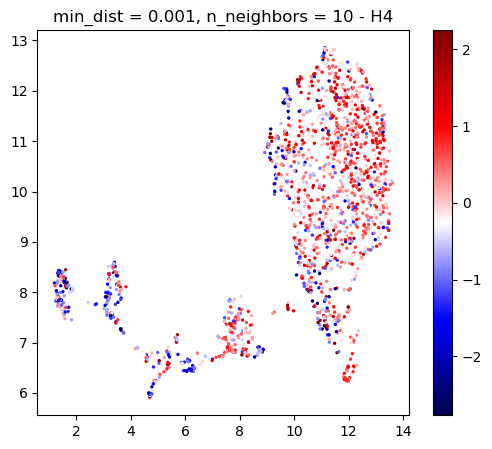

In [29]:
min_dist,n_neighbors = getValsCsv(vars = ['all','umap',j])
print(min_dist,n_neighbors)
umapData = calculate_umap(CAll[CellIden_EpiCols],n_neighbors, min_dist)
drawUMAP(umapData, ['H4'],CAll,settings,
            title = f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
            Figname = name+'1_UMAP_(core)')
    


# umap_params(k,MRK,dir_plots,
#             valA = min_dist, valB = n_neighbors,
#             )

# umap_params(k,MRK,dir_plots,
#             valA = 0.2, valB = 300,
#             )
# umap_params(k,MRK,dir_plots,
#             valA = 0.1, valB = 300,
#             )

# umap_params(k,MRK,dir_plots,
#             valA = 0.001, valB = 300,
#             )

### Dbscan and clusters

0.19 50
Estimated number of clusters: 6
Estimated number of noise points: 449
Silhouette Coefficient: 0.042


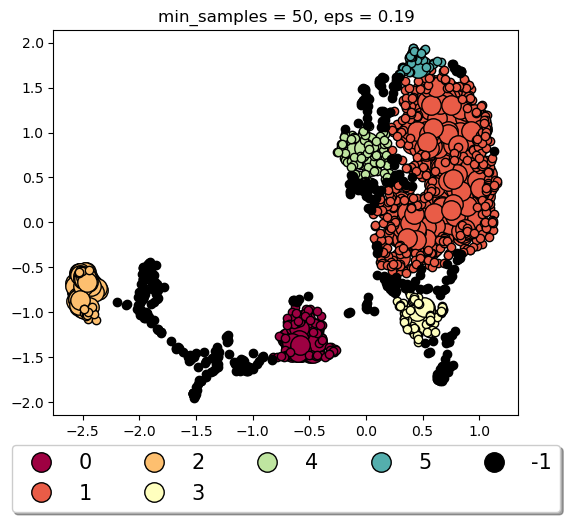

In [30]:
eps,min_samples = getValsCsv(vars = ['all','db',j])
print(eps,min_samples)
dbscanData,labels,core_samples_mask = calculate_dbscan(umapData,eps=eps,min_samples=min_samples)
drawDbscan(dbscanData,labels,core_samples_mask,settings,
            title=f'min_samples = {min_samples}, eps = {eps}',
            figname = name+'1_dbscan')
              
# dbscan_params(X_2d,dir_plots,
#                   valA = eps, valB = min_samples,
#                   itersA = 3, itersB = 3,
#                   )
# l = labels==4
# s['min_samples']['1245']=70
# s['eps']['1245']=0.2
# dbscanData_,labels_,core_samples_mask_ = calculate_dbscan(umapData[l],eps=eps,min_samples=min_samples)
# labels[l] = labels_
# drawDbscan(dbscanData,labels,core_samples_mask,settings,
#               title=f'min_samples = {min_samples}, eps = {eps}',
#               figname = name+'1_dbscan')

/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/yishai/anaconda3/envs/tf_39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


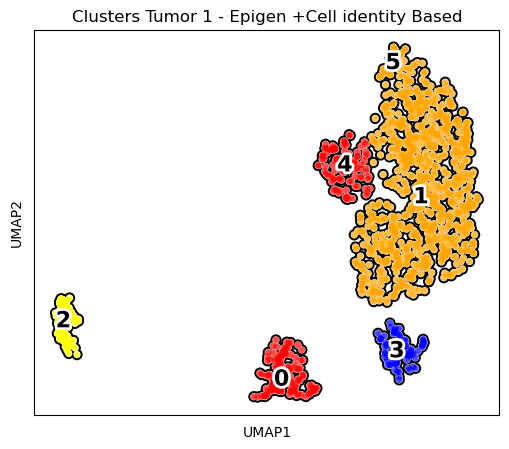

In [31]:

plotClusters(k,umapData,labels,NamesAll,settings,
             title = 'Clusters Tumor '+j+' - Epigen +Cell identity Based',
             figname = name+'1_Clusters')


## HeatMap by cluster

In [32]:

if visualize:
    for group_name,group in zip(groups[0],groups[1]):
    
        HeatMap(k[k.Clust!=-1],group,settings,
                title = 'T'+j+' Epigen+Cell Based: '+group_name,
                figname = name+'1_HeatMap_'+group_name)  


### HeatMap by sample

In [33]:
if visualize and not singleSample:
    for group_name,group in zip(groups[0],groups[1]):
        group_name,group = groups[0][-1],groups[1][-1]
        HeatMap(k[k.Clust!=-1],group,settings,clustFeature='by_sample',
                title = 'T'+j+' Cell Iden Based: '+group_name+'by_sample',
                figname = name+'1_HeatMap_'+group_name+'by_sample')


## Meandist

In [34]:

if visualize:
    for group_name,group in zip(groups[0],groups[1]):
        MeanDist(k [k.Clust==0],k [k.Clust==1],group,settings,
                title='MeanDist Epigen+Cell based: '+group_name,
                figname = name+'1_MeanDist_'+group_name)


## sample percentage

In [35]:
if visualize and not singleSample:
    # unique by_sample values
    sampNums = np.unique(k['by_sample'])
    for sampNum in sampNums:
        drawUMAPbySample(umapData, k, sampNum,'by_sample',settings,
                            title =name+' UMAP', 
                            Figname = name+f'4_UMAP_sample{sampNum}')

    arr =[]
    clustNums = np.unique(k.Clust); clustNums = clustNums[clustNums!=-1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind],'by_sample')

        arr.append([clustNum,PercentageBySample])
    saveCsv(dir_plots,name,arr)

## samples correlation

In [36]:
if not singleSample:
    createCorrMat(k.groupby(by='by_sample').mean(),method ='spearman',
                settings = settings,title=name,figname = name)

## features on UMAP

In [37]:

if visualize and plotUMAP:
    drawUMAP(umapData, NamesAll,CAll,settings,
            title =name+' UMAP', 
            Figname = name+'2_UMAP_')


# figures

In [38]:

if visualize :
    scatter(k,'NCad','ECad',name,settings)

## save data to file

In [39]:
dbscanData, umapData,k, CAll,labels,s = None,None,None,None,None,None

# copy to single pdf

In [40]:
dict ={}
dict['k'] = k_orig
# pickle_dump('k'+j+'_sample', dict,dir_data)

# imList2pdf(dir_plots,j,['CellIden','EpiCols','CellIden+EpiCols'])

end = time.process_time()
print ('total run time =', end-start )

total run time = 48.6590727


In [41]:
# imList2pdf(dir_plots,j,['CellIden','EpiCols','CellIden+EpiCols'])